# Problem Statement

Assuming the production instance of Reddit went down recently which led to many posts getting stuck in the queue to be processed. Unfortunately, at the juncture when the Subreddit tag was to be tagged to the post, the system went down and thus was not able to tag the post successfully. The aim of this project is to then classify a post back into the correct Subreddit in the most accurate manner by using machine learning and Neuro-Linguistic Programming (NLP) techniques. This will be a binary classification problem consisting of posts from two Subreddits, _r/MentalHealth_ and _r/Psychology_. 

_r/MentalHealth_ and _r/Psychology_ were chosen because it is neither too similar nor too different. There are overlapping topics and we can see if the accuracy of the classification is indeed going to be good or bad. 

A few machine learning models will be going through supervised learning to be trained on existing data from each Subreddit. The model with the best accuracy will be the model of choice for this classfication problem. This model can continue to train on new data for new posts to enhance its accuracy.  

# Content Page

- [Web Scrapping](#Web-Scrapping---requests-library)
- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)
- [Pre-processing](#Pre-processing)
- [Baseline Accuracy](#Baseline-Accuracy)
- [Model Prep](#Model-Prep)
- [Pipeline](#Pipeline)
- [Vectorizing with best params](#Vectorizing-with-the-best-params)
- [Logistic Regression](#Logistic-Regression-Model)
- [Naive-Bayes](#Naive-Bayes-Model)
- [Random Forest](#Random-Forest-Model)
- [Summary](#Summary)

# Executive Summary

In recent years, there has been many cases of suicide rates increasing, mental health disorders skyrocketing and hitting millions of people in the world. Understanding the texts through NLP of two subreddits _r/MentalHealth_ and _r/Psychology_ are good starting points for a classification task. 

Data is gathered by scrapping posts from the two popular subreddits and then training the model on 75% of the data and subsequently the other 25% as the unseen test set to evaluate the model performance. The models used will be:
- Logistic Regression
- Naive-Bayes Classifier
- Random Forest Classifier

After the training and testing phases, Logistic Regression performed the best in terms of the accuracy score. But in terms of the interpretability of the features and that it includes nearby words as well, **Naive-Bayes Classifer** is ultimately the model of choice for this classification problem. Misclassification rate is also relatively low and they are mostly due to uncontrollable factors wherein the posts that usually appears in _r/Psychology_ appeared in _r/MentalHealth_ and vice versa. 

However, to truly increase the performance of the model, further research on understanding texts through linguistic features and contextualisation would need to be performed. Identifying and inputting more features into the model can also aid in increasing accuracy scores as well. Ultimately, to further tune the model we have to use an interpretable model in either Logistic Regression or Naive-Bayes Classifier to read the results to ensure it makes sense apart from just the accuracy scores.    

In [604]:
#Import all neccessary dependencies
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')

import praw
import pandas as pd
import regex as re
import numpy as np

In [135]:
#setting pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Web Scrapping - requests library

In [17]:
url = 'https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100' #getting all 100 top of all time posts
res = requests.get(url, headers={'User-agent': 'GG Inc 1.0'})

Ensuring the status code = 200, meaning we are good to go. 

In [18]:
res.status_code

200

In [19]:
reddit_dict = res.json()

In [20]:
reddit_dict.keys()

dict_keys(['kind', 'data'])

In [21]:
reddit_dict['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [22]:
#total of 100 reddit posts per request, all posts are under the data -> children 
len(reddit_dict['data']['children'])

100

In [26]:
posts = []
after = None

for a in range(10):
    if after == None:
        current_url = url
    else:
        current_url = url + ';after=' + after
    print(current_url)
    res = requests.get(current_url, headers={'User-agent': 'Lola Inc 1.0'})
    
    if res.status_code != 200:
        print('Status error', res.status_code)
        break
    
    current_dict = res.json()
    current_posts = [p['data'] for p in current_dict['data']['children']]
    posts.extend(current_posts)
    after = current_dict['data']['after']
    print(after)
    # generate a sleep duration to look more 'natural'
    sleep_duration = 2
    print(sleep_duration)
    time.sleep(sleep_duration)

https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100
t3_8akw3d
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_8akw3d
t3_adsv20
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_adsv20
t3_brr6td
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_brr6td
t3_d1ww3q
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_d1ww3q
t3_bncdlw
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_bncdlw
t3_dj50g0
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_dj50g0
t3_97u50i
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_97u50i
t3_697tsp
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_697tsp
t3_9z5523
2
https://www.reddit.com/r/mentalhealth/top.json?t=all;limit=100;after=t3_9z5523
t3_bet6d0
2


Generally, if the `after` tag for the url is always different for each iteration, the chances of duplication are almost zero. 

In [27]:
#ensure that there are 1000 posts
len(posts)

1000

In [31]:
#ensuring there are no duplicates
post_check = {i['id']: i['title'] for i in posts}

In [32]:
#true enough no duplicates and we are good to go!
len(post_check)

1000

This is to show that it is possible to do web scrapping using the `requests` library. However, there is another cleaner method which can be done fewer lines of code which will be shown below.

# Web Scrapping - praw library

For this to work, we have to install another library called, `praw` and subsequently create your own reddit app which can be easily done in a minute. 

In [315]:
#Init the reddit instance
reddit = praw.Reddit(client_id='xX4XqcPrWbcaFw',
                     client_secret='RWHjSQXiQIZIao54qQtrNJZLegE',
                     user_agent='mac:redditclassifier:v0.1'
                    )

In [316]:
#read only flag as we do not want to write anything
print(reddit.read_only) 

True


Subreddit chosen: MentalHealth & Psychology

## Scrapping /r/MentalHealth

In [317]:
#MentalHealth containers
mh_dict = {}
mh_title = []
mh_text = []

In [318]:
#getting top 1000 posts from r/mentalhealth
for submission in reddit.subreddit('mentalhealth').top(limit=1000):
    mh_title.append(submission.title)
    mh_text.append(submission.selftext)
mh_dict['title'] = mh_title
mh_dict['text'] = mh_text

In [319]:
#verifying count of posts
len(mh_title)

1000

In [350]:
#adding scrapped post into a DataFrame
mh_df = pd.DataFrame(mh_dict)

In [321]:
#checking shape of DataFrame
mh_df.shape

(1000, 2)

In [322]:
mh_df['title'].count()

1000

In [323]:
#na sum is 0 because the blanks are just blanks are not NA
mh_df.isna().sum()

title    0
text     0
dtype: int64

In [324]:
print('Number of blank selftext:')
mh_df[mh_df['text']==''].count()

Number of blank selftext:


title    278
text     278
dtype: int64

## Scrapping r/Psychology

In [340]:
p_dict = {}
p_title = []
p_text = []

In [341]:
for submission in reddit.subreddit('psychology').top(limit=1000):
    p_title.append(submission.title)
    p_text.append(submission.selftext)
p_dict['title'] = p_title
p_dict['text'] = p_text

In [342]:
#number of posts
len(p_dict['title'])

998

In [343]:
#putting into a DataFrame
p_df = pd.DataFrame(p_dict)

In [344]:
p_df.shape

(998, 2)

In [345]:
#There are no text as they are mostly links to external journal websites or articles. 
p_df[p_df['text']==''].count()

title    995
text     995
dtype: int64

# Data Cleaning

## Combining title and text

In [351]:
mh_df.head()

,title,text
0,Mental Health Awareness Month: I have schizoaf...,
1,"Not to brag, but instead of laying in bed ALL ...",
2,I made a suicide scale. Hoping it could help o...,[suicide scale](https://emmengard.com/2019/05/...
3,PREACH,
4,It’s been 2 months to the day since I last sel...,


In [352]:
#concatenating of title and the post text
mh_df['title_txt'] = mh_df['title'] + " " + mh_df['text']

In [353]:
mh_df.head()

,title,text,title_txt
0,Mental Health Awareness Month: I have schizoaf...,,Mental Health Awareness Month: I have schizoaf...
1,"Not to brag, but instead of laying in bed ALL ...",,"Not to brag, but instead of laying in bed ALL ..."
2,I made a suicide scale. Hoping it could help o...,[suicide scale](https://emmengard.com/2019/05/...,I made a suicide scale. Hoping it could help o...
3,PREACH,,PREACH
4,It’s been 2 months to the day since I last sel...,,It’s been 2 months to the day since I last sel...


In [356]:
#concatenating of title and the post text
p_df['title_txt'] = p_df['title'] + " " + p_df['text']

In [376]:
p_df.head()

,title,text,title_txt,class
0,Millennials Aren't Coddled - They Just Rejec...,,Millennials Aren't Coddled - They Just Rejec...,0
1,Study: Atheists behave more fairly toward Chri...,,Study: Atheists behave more fairly toward Chri...,0
2,Editor asked to resign from journal for saying...,,Editor asked to resign from journal for saying...,0
3,A frequently cited study claiming that exposur...,,A frequently cited study claiming that exposur...,0
4,Men's historical dominance of the workplace ma...,,Men's historical dominance of the workplace ma...,0


In [358]:
# Assigning the negative and positive class
# MentalHealth: 1, Psychology: 0
mh_df['class'] = 1
p_df['class'] = 0

## Combining both subreddits

In [359]:
#combine both together
comb_df = mh_df.append(p_df, ignore_index=True)

In [360]:
comb_df['class'].value_counts()

1    1000
0     998
Name: class, dtype: int64

In [361]:
#drop those columns we do not need
comb_df.drop(columns=['title', 'text'], inplace=True)

In [362]:
comb_df['class'].value_counts()

1    1000
0     998
Name: class, dtype: int64

__Saving into csv__

In [364]:
comb_df.to_csv('../datasets/comb_subreddits_final.csv')

## Removing links

In [365]:
#Read from csv
comb_df = pd.read_csv('../datasets/comb_subreddits_final.csv')
comb_df.drop('Unnamed: 0', axis=1, inplace=True)

In [366]:
comb_df.head()

,title_txt,class
0,Mental Health Awareness Month: I have schizoaf...,1
1,"Not to brag, but instead of laying in bed ALL ...",1
2,I made a suicide scale. Hoping it could help o...,1
3,PREACH,1
4,It’s been 2 months to the day since I last sel...,1


In [367]:
#number of websites before
comb_df[comb_df['title_txt'].str.contains('\.com|\.org')].count()

title_txt    51
class        51
dtype: int64

In [381]:
def remove_links(x):
#removing links from the set
    return re.sub(r"((http|ftp|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", x)

In [382]:
#remove links
comb_df['title_txt'] = comb_df['title_txt'].map(remove_links)

In [383]:
comb_df.head()

,title_txt,class
0,Mental Health Awareness Month: I have schizoaf...,1
1,"Not to brag, but instead of laying in bed ALL ...",1
2,I made a suicide scale. Hoping it could help o...,1
3,PREACH,1
4,It’s been 2 months to the day since I last sel...,1


In [387]:
#Save to csv
comb_df.to_csv('../datasets/comb_subreddits_final_clean.csv')

# EDA

## Wordcloud

In [842]:
#specifying own stopwords
stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would"] \
+ ['mental', 'health', 'was', 'really', 'let']
stopwords = set(stopwords)

In [395]:
#init wordcloud instance
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_font_size=80, max_words=20)

__MentalHealth WordCloud__

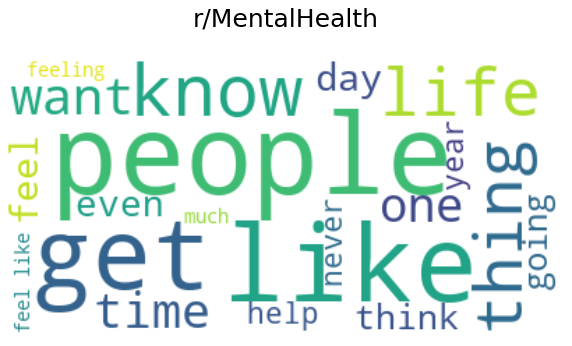

In [396]:
#subreddit title and text has to be one single string
mh_text =' '.join([txt for txt in comb_df[comb_df['class']==1].loc[:,'title_txt']]).lower()
wordcloud.generate(mh_text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.gca().set_title("r/MentalHealth\n", fontsize=25)
plt.axis("off")
plt.show()

__Psychology WordCloud__

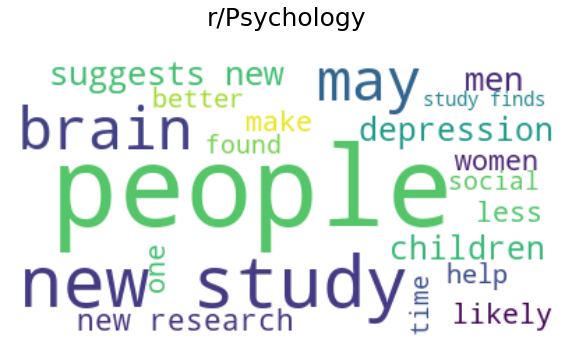

In [397]:
#subreddit title and text has to be one single string
p_text =' '.join([txt for txt in comb_df[comb_df['class']==0].loc[:,'title_txt']]).lower()
wordcloud.generate(p_text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.gca().set_title("r/Psychology\n", fontsize=25)
plt.axis("off")
plt.show()

Wordclouds show the words that have high frequency, before doing any stemming or lemmatization. 

For _r/MentalHealth_, there are more verbs as compared to _r/Psychology_. In _r/Psychology_, the dominant words are mostly nouns like "new study", "people", "new research".

## Top unigram plots

In [843]:
def get_top_n_unigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

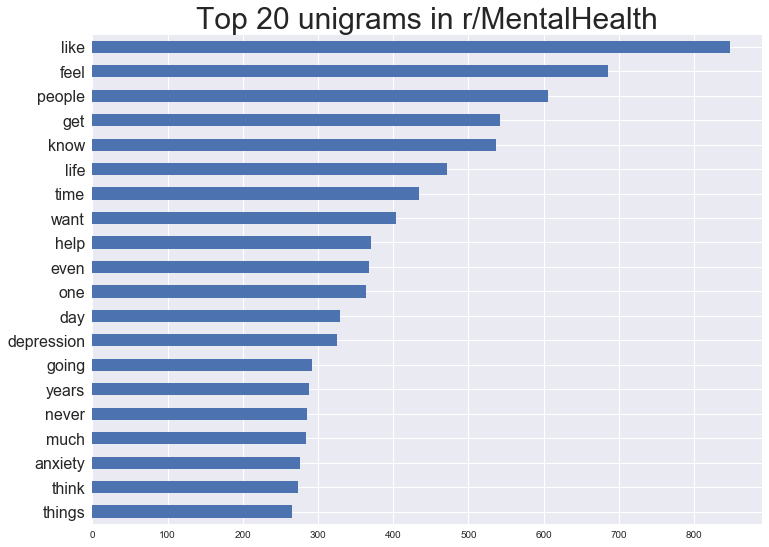

In [844]:
#common unigrams for MentalHealth
common_words_mh = get_top_n_unigram(comb_df[comb_df['class']==1]['title_txt'], 20)

unigram_df = pd.DataFrame(common_words_mh, columns = ['text' , 'count'])

plt.figure(figsize=(12, 9));
unigram_df.groupby('text').sum()['count'].sort_values(ascending=True).plot(
    kind='barh');
plt.ylabel('');
plt.title('Top 20 unigrams in r/MentalHealth', fontdict={'fontsize': 30});
#set large enough font size for ytick labels 
plt.gca().tick_params(axis='y', labelsize=16);

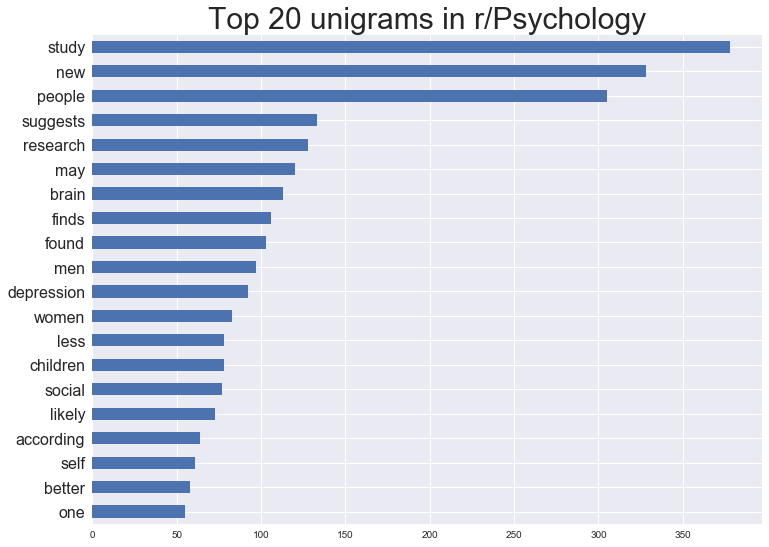

In [845]:
#common unigrams for Psychology
common_words_mh = get_top_n_unigram(comb_df[comb_df['class']==0]['title_txt'], 20)

p_unigram_df = pd.DataFrame(common_words_mh, columns = ['text' , 'count'])

plt.figure(figsize=(12, 9));
p_unigram_df.groupby('text').sum()['count'].sort_values(ascending=True).plot(
    kind='barh');
plt.ylabel('');
plt.title('Top 20 unigrams in r/Psychology', fontdict={'fontsize': 30});
#set large enough font size for ytick labels 
plt.gca().tick_params(axis='y', labelsize=16);

## Top bigram plots

Just looking at single words are not enough to have sense of what the posts are talking about. Bigrams helps to include one more word so that we can still make sense of some context. 

In [398]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

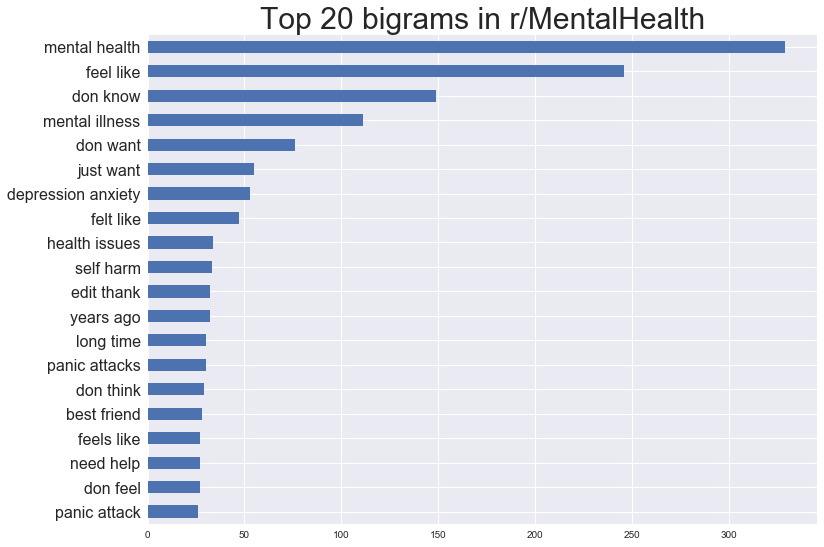

In [633]:
#common bigrams for MentalHealth
common_words_mh = get_top_n_bigram(comb_df[comb_df['class']==1]['title_txt'], 20)

df4 = pd.DataFrame(common_words_mh, columns = ['text' , 'count'])

plt.figure(figsize=(12, 9));
df4.groupby('text').sum()['count'].sort_values(ascending=True).plot(
    kind='barh');
plt.ylabel('');
plt.title('Top 20 bigrams in r/MentalHealth', fontdict={'fontsize': 30});
#set large enough font size for ytick labels 
plt.gca().tick_params(axis='y', labelsize=16);

Apart from the words "mental health", the posts are generally about expressing how the author is feeling, with "don know", "feel like", "just want". Also very interesting is that "edit thank" is also part of the top 20 bigrams, showing that the author went back to edit the post to thank Redditors (people on Reddit) for their support of their post. This proves that _r/MentalHealth_ has generally a supportive following.    

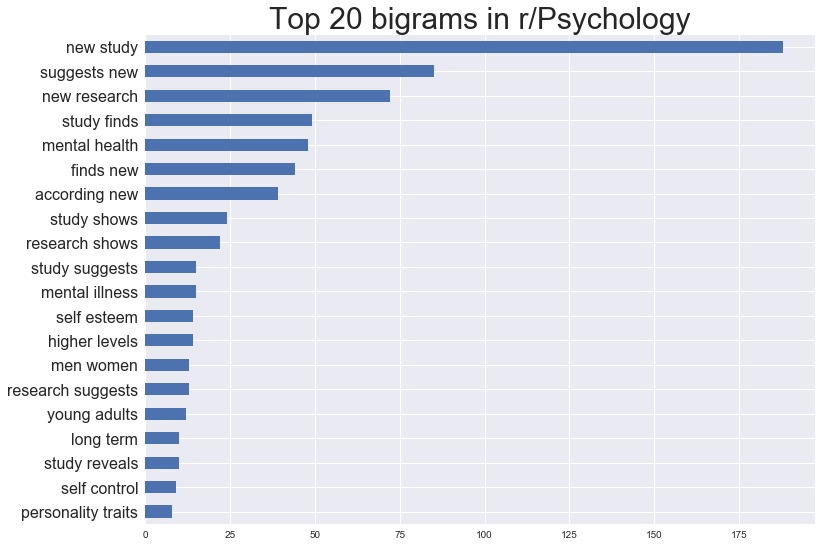

In [631]:
#common words for Psychology
common_words_p = get_top_n_bigram(comb_df[comb_df['class']==0]['title_txt'], 20)

df5 = pd.DataFrame(common_words_p, columns = ['text' , 'count'])

plt.figure(figsize=(12, 9));
df5.groupby('text').sum()['count'].sort_values(ascending=True).plot(
    kind='barh');
plt.ylabel('');
plt.title('Top 20 bigrams in r/Psychology', fontdict={'fontsize': 30});
#set large enough font size for ytick labels 
plt.gca().tick_params(axis='y', labelsize=16);

Whereas for _r/Psychology_, it is a Subreddit where Redditors mostly share new discoveries or studies in the realm of Psychology, with bigrams like "new study", "suggests new", "new research", "study finds" quickly appearing as the top 5. The bigrams "mental health", "mental illness" also show up here which indicates that they are overlapping topics with _r/MentalHealth_ and rightly so. 

## Sentiment relationship plot

Apart from the counts of words and bigrams, it is also interesting to see how the sentiment of the posts are generally. 

In [419]:
from textblob import TextBlob

def get_polarity(x):
    blob = TextBlob(x)
    return blob.polarity

def get_subjectivity(x):
    blob = TextBlob(x)
    return blob.subjectivity    

__Exploring what polarity and subjectivity means__

Polarity refers to how positive or negative the post is while subjectivity refers to how subjective or objective the post is. Both are Sentiment indicators. 

In [737]:
#looking at a post sentiment
blob = TextBlob(comb_df.loc[1234, 'title_txt'])
print(blob)
blob.sentiment

Eating mushrooms may reduce the risk of cognitive decline: Seniors who eat more than 300 grams of cooked mushrooms per week have reduced odds of developing mild cognitive impairment. 


Sentiment(polarity=0.41666666666666663, subjectivity=0.5)

The Sentiment attribute consists of both polarity and subjectivity values given a text. Polarity is a float within the range of \[-1, 1\] while subjectivity is a float within the range of \[0, 1\].

In this particular example, this post is from _r/Psychology_ and states the title of the article. Since eating a certain amount of mushrooms will potentially have reduced odds of developing mild cognitive impairment, the polarity (~0.417) given to this is quite positive. 

The subjectivity of the post is quite neutral at 0.5 which is very typical of news headlines. 

<span style="color:maroon"> _Warning: Negative sentiment ahead_ </span>

In [750]:
#looking at a post sentiment
blob = TextBlob(comb_df.loc[167, 'title_txt'])
print(blob)
blob.sentiment

You ever have that feeling that your friends secretly hate you? 


Sentiment(polarity=-0.8, subjectivity=0.9)

Polarity here is much more negative here at -0.8 likely due to the word hate. 

Subjectivity of 0.9 shows that there is a high influence of the author's own feelings and opinions on this post. 

In [753]:
#looking at a post sentiment
blob = TextBlob(comb_df.loc[455, 'title_txt'])
print(blob)
blob.sentiment

I am finally getting therapy. EDIT: thank you all so much for the positive responses!!! that is so cool, it makes me feel better to know there is a wonderful community of support here!!! Thank you from the bottom of my heart and good luck to you all on your adventures xx will keep you all updated :D

&#x200B;

&#x200B;

Hi all!

I just want to post here to say that I am finally getting therapy and I am so very proud of myself! I'm not being stubborn anymore. I have been neglecting my mental health for years in a strange way. Instead of seeking professional help, I've been trying to help myself by reading self-help books and articles on the internet. The only thing that did for me was inform me. Even though I've read about mental health, I've never actually applied anything to my life. If I did, it just drove me into a downwards spiral because it was like my own mentally ill mind talking to my own mentally mind. I didn't get very far at all.

I tried therapy once but stopped going withi

Sentiment(polarity=0.22084745332792208, subjectivity=0.5310808982683983)

The polarity for this post in _/r/MentalHealth_ tends towards a more positive note as the author poured his/her feelings about finally going for therapy and then editing the post to thank redditors for their immense support. Furthermore, it is worth noting that the the general feel about this post is that the author is being excited at finally going for therapy which explains why the polarity is a postive one.

This post is more subjective due to the fact that the author is talking about his/her own feelings and opinions about his own mental health. 

In [421]:
#assign polarity and subjectivity for each post
comb_df['polarity'] = comb_df['title_txt'].map(get_polarity)
comb_df['subjectivity'] = comb_df['title_txt'].map(get_subjectivity)

In [826]:
#getting average polarity and subjectivity for the different Subreddits. 
comb_df.groupby('class').mean()

,polarity,subjectivity
class,,
0,0.093330,0.432508
1,0.078134,0.465173


The mean polarity for each subreddit has a is slightly lower for _r/Psychology_ then _r/MentalHealth_ as redditors often talk about how they feel in _r/MentalHealth_. Usually since it is a help forum, people only tend to post if they are feeling somewhat under the weather. The positive thing about this though, is that it is an encouraging community generally.  

The mean subjectivity of the posts in _r/Psychology_ is lower than that of _r/MentalHealth_. This is probably because most of the posts in _r/Psychology_ are more general news articles and thus is more neutral. 

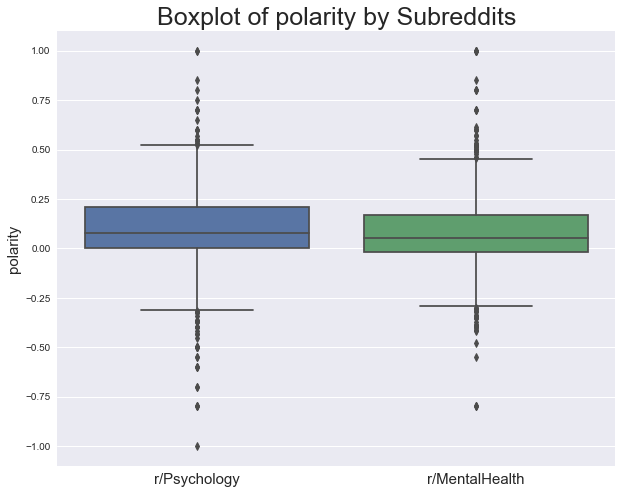

In [832]:
plt.figure(figsize=(10,8))
sns.boxplot(data=comb_df, x='class', y='polarity');
plt.xticks([0, 1], labels=['r/Psychology', 'r/MentalHealth'], fontsize=15);
plt.xlabel('');
plt.ylabel('polarity', fontdict={'fontsize': 15});
plt.title('Boxplot of polarity by Subreddits', fontdict={'fontsize': 25});

The outliers from _r/Psychology_ are more skewed towards negative polarity values. This is interesting because this subreddit posts more news articles and new results from studies which may contain the facts as they are. For example, for the 2 posts: "Two studies suggesting a link between violent video games and real-life behavior have been retracted" and "The Religion of Workism Is Making Americans Miserable", have the words "violent" and "miserable" as very strong negative polarity.

Wheras for _r/MentalHealth_, it tends to be a more positive polarity, with fewer outliers in the negative ranges. 

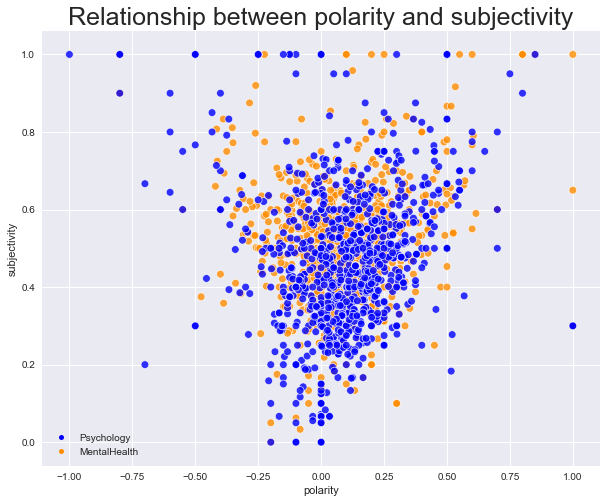

In [798]:
from matplotlib.lines import Line2D

#speicfy custom legend
custom = [Line2D([], [], marker='.', color = 'blue' ,linestyle='None', markersize=10),
          Line2D([], [], marker='.', color='darkorange', linestyle='None', markersize=10)]

plt.figure(figsize=(10,8));
ax = sns.scatterplot(comb_df['polarity'], comb_df['subjectivity'], palette=['blue', 'darkorange'] , hue=comb_df['class'], s=60, alpha=0.8);
plt.title('Relationship between polarity and subjectivity', fontdict={'fontsize': 25});
ax.legend(custom, ['Psychology', 'MentalHealth']);

Judging by how different these two variables are, it is worthwhile to see if there is any trend between the two variables. Based on the scatter plot, it is not convincing that there is a relationship as they mostly scatter towards the centre. 

There is also an overlap of many orange and blue points signalling that the relationship between polarity and subjectivity is the same for both Subreddits.

# Pre-processing

## Tokenzing

Tokenizing helps in breaking down each sentence into words to prepare the data for vectorizing. 

In [388]:
# Import Tokenizer
from nltk.tokenize import RegexpTokenizer

In [389]:
#only take words or numbers in
tokenizer = RegexpTokenizer(r'\w+', gaps=False)

In [390]:
comb_df['tokens'] = comb_df['title_txt'].map(tokenizer.tokenize)

In [392]:
comb_df.head()

,title_txt,class,tokens
0,Mental Health Awareness Month: I have schizoaf...,1,"[Mental, Health, Awareness, Month, I, have, sc..."
1,"Not to brag, but instead of laying in bed ALL ...",1,"[Not, to, brag, but, instead, of, laying, in, ..."
2,I made a suicide scale. Hoping it could help o...,1,"[I, made, a, suicide, scale, Hoping, it, could..."
3,PREACH,1,[PREACH]
4,It’s been 2 months to the day since I last sel...,1,"[It, s, been, 2, months, to, the, day, since, ..."


## Lemmatizing & Stemming

In [14]:
import nltk

In [872]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def stem_lem(x):
#-----------------------------------
# Input:
# x - post text
# Output:
# string of lemmatized and stemmed words
#-----------------------------------
    lemmatizer = WordNetLemmatizer()
    p_stemmer = PorterStemmer()
    
    
    #lemmatize words
    lemm_words = [lemmatizer.lemmatize(word.lower()) for word in x]

    # Stem words.
    stemmed_words = [p_stemmer.stem(word) for word in lemm_words]
    
    #return lemmatized and stem words in a string
    return ' '.join(stemmed_words)  

Porter Stemming uses suffix removal to get the base words while Lemmatization reduces the word to a base word that belongs to the language. We will use both since we are not interested in context here.

In [476]:
comb_df['txt_lem'] = comb_df['tokens'].map(stem_lem)

In [477]:
comb_df['txt_lem'].head()

0    mental health awar month i have schizoaffect b...
1    not to brag but instead of lay in bed all day ...
2    i made a suicid scale hope it could help other...
3                                               preach
4    it s been 2 month to the day sinc i last self ...
Name: txt_lem, dtype: object

In [478]:
comb_df.head()

,title_txt,class,tokens,polarity,subjectivity,txt_lem
0,Mental Health Awareness Month: I have schizoaf...,1,"[Mental, Health, Awareness, Month, I, have, sc...",0.160000,0.448333,mental health awar month i have schizoaffect b...
1,"Not to brag, but instead of laying in bed ALL ...",1,"[Not, to, brag, but, instead, of, laying, in, ...",0.250000,0.250000,not to brag but instead of lay in bed all day ...
2,I made a suicide scale. Hoping it could help o...,1,"[I, made, a, suicide, scale, Hoping, it, could...",0.143333,0.620000,i made a suicid scale hope it could help other...
3,PREACH,1,[PREACH],0.000000,0.000000,preach
4,It’s been 2 months to the day since I last sel...,1,"[It, s, been, 2, months, to, the, day, since, ...",0.400000,0.533333,it s been 2 month to the day sinc i last self ...


# Baseline Accuracy

In [481]:
comb_df['class'].value_counts(normalize=True)

1    0.500501
0    0.499499
Name: class, dtype: float64

# Model Prep

In [482]:
X = comb_df['txt_lem']
y = comb_df['class']

## Train/Test Split

In [483]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [487]:
#ensure that the value counts are quite evenly distributed
y_train.value_counts()

1    750
0    748
Name: class, dtype: int64

# Pipeline

Pipeline is used to get the best parameters for the CountVectorizer. 

In [846]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegression(solver='liblinear'))
])

In [848]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 5000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9225634178905207


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

The best parameters are the above, which is to ignore document frequency above 90% and below 3. Finally, restricting the max features (number of words) to 2500 and using unigrams and bigrams got the best score. 

In [849]:
gs.score(X_test, y_test)

0.948

# Vectorizing with the best params

Initialising the CountVectorizer with the best parameters found by Grid Search algorithm. 

In [850]:
cvec = CountVectorizer(max_df=0.9, max_features=3500, min_df=3, ngram_range=(1,2), stop_words=stopwords)

In [851]:
X_train_cvec = cvec.fit_transform(X_train, y_train).todense()

In [852]:
X_test_cvec = cvec.transform(X_test).todense()

In [854]:
X_train_cvec.shape

(1498, 3500)

# Logistic Regression Model

## Using GridSearch to find the best C

In [855]:
logreg = LogisticRegression(solver='liblinear')
log_reg_params = {
    'C': np.linspace(1, 10)
}

In [858]:
gs_logreg = GridSearchCV(logreg, param_grid=log_reg_params, cv=3)
gs_logreg.fit(X_train_cvec, y_train)
print(gs_logreg.best_score_)
gs_logreg.best_params_

0.9259012016021362


{'C': 1.5510204081632653}

In [861]:
gs_logreg.score(X_train_cvec, y_train)

0.9986648865153538

In [860]:
gs_logreg.score(X_test_cvec, y_test)

0.948

## Re-initialising Logistic Regression Model with best parameters

In [864]:
#reinit logistic regression again with the right params
logreg = LogisticRegression(C=1.5510204081632653, solver='liblinear')
logreg.fit(X_train_cvec, y_train)

LogisticRegression(C=1.5510204081632653, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [962]:
print('Logistic Regression Model Train Score:', logreg.score(X_train_cvec, y_train))
print('Logistic Regression Model Test Score:', logreg.score(X_test_cvec, y_test))

Logistic Regression Model Train Score: 0.9986648865153538
Logistic Regression Model Test Score: 0.948


## Top features by subreddit

In [866]:
coefs=logreg.coef_[0]

In [867]:
word_coef = pd.DataFrame({'word': cvec.get_feature_names() , 'coeff': np.exp(coefs)})

In [873]:
print("Top 20 Features for Logistic Regression (r/MentalHealth)")
word_coef.sort_values(by='coeff' , ascending=False).head(20)

Top 20 Features for Logistic Regression (r/MentalHealth)


,word,coeff
2896,thi,4.559811
2162,pleas,2.894232
1713,love,2.761995
228,anyon,2.619562
1048,feel like,2.572761
1679,live,2.509398
1213,go,2.485546
1698,look,2.321109
3087,toxic,2.315257
1147,fuck,2.298519


The top words notably are love, feel like, f\*\*k, toxic, live, which are alot of subjective words that describe the author's feelings and opinions.  The way we interpret the coefficient is that with every 1 unit increase in the word count for love, it is 2.76 times more likely that it will be from _r/MentalHealth._ 

In [876]:
print("Top 20 Features for Logistic Regression (r/Psychology)")
word_coef.sort_values(by='coeff' , ascending=False).tail(20).sort_values(by='coeff', ascending=True)

Top 20 Features for Logistic Regression (r/Psychology)


,word,coeff
2738,studi,0.067345
2376,research,0.130941
431,brain,0.153658
2250,psycholog,0.182447
1587,le,0.231595
2340,reduc,0.260258
2254,psychopath,0.322305
1590,lead,0.330040
1811,men,0.334390
517,child,0.335611


Studies and research are the top words for a classification into _r/Psychology_. With every unit increase of studies, it is 0.07 and 0.13 times respectively as likely to be classifed as _r/MentalHealth_. Thus these two words will be classified as _r/Psychology_.

In [877]:
len(logreg.coef_[0])

3500

In [500]:
#create mega function to draw roc curve
def draw_roc(df, true_col, pred_prob_col, model_name):
    # Create figure.
    plt.figure(figsize = (10,7))

    # Create threshold values. (Dashed red line in image.)
    thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
    def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)

    # Define function to calculate 1 - specificity. (False positive rate.)
    def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(df, true_col, pred_prob_col, prob) for prob in thresholds]
    fpr_values = [FPR(df, true_col, pred_prob_col, prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {round(roc_auc_score(df[true_col], df[pred_prob_col]),3)}\n({model_name})',fontsize=22)
    plt.ylabel('Sensitivity - False Positive Rate', fontsize=18)
    plt.xlabel('1 - Specificity - True Positive Rate', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

In [878]:
#construct list of probabilities
pred_proba_logreg = [i[1] for i in logreg.predict_proba(X_test_cvec)]

In [879]:
print("ROC AUC Score: ", roc_auc_score(y_test, pred_proba_logreg))

ROC AUC Score:  0.979784


In [880]:
#Put the actual values and predicted probabilities in a dataframe
pred_logreg_df = pd.DataFrame({'actual': y_test, 'pred': pred_proba_logreg})

In [881]:
pred_logreg_df['predict'] = logreg.predict(X_test_cvec)

In [882]:
#put all misclassifications into a dataframe
pred_false_logreg = pred_logreg_df[pred_logreg_df['actual'] != pred_logreg_df['predict']]

In [883]:
pred_false_logreg.head()

,actual,pred,predict
386,1,0.002905,0
407,1,0.000003,0
234,1,0.453056,0
488,1,0.025572,0
730,1,0.492146,0


In [884]:
#getting the false positives and false negatives to be saved in a csv
comb_df.loc[pred_false_logreg.index, :].merge(pred_false_logreg, left_index=True, right_index=True).to_csv('../datasets/predict_false_logreg.csv')

In [885]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_logreg_df['predict']).ravel()

In [886]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 239
False Positives: 11
False Negatives: 15
True Positives: 235


This model does pretty well on classifying the posts into either subreddits. Most of the classifications are correct while leaving only some misclassification at 26, accounting for 0.053 of the total.

## ROC Curve

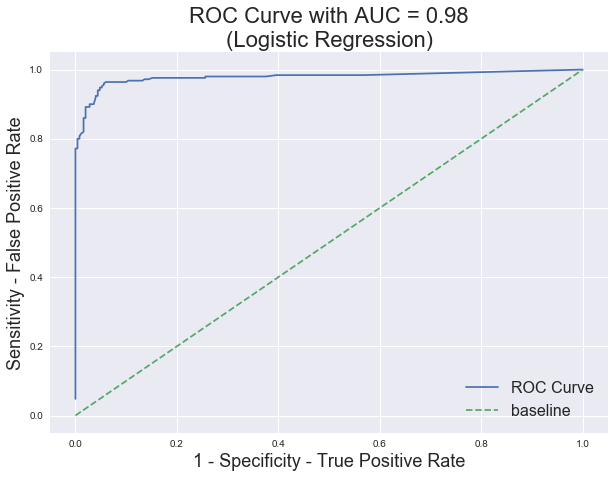

In [887]:
draw_roc(pred_logreg_df, "actual", "pred", 'Logistic Regression')

The ROC Curve shown above shows that the two classes are quite distinct with the area under the curve as quite large and does not lie on the baseline. This means that the classification is very distinct between the two classes. 

# Naive-Bayes Model 

In [888]:
#init our naive bayes model
nb = MultinomialNB()

In [889]:
nb.fit(X_train_cvec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [905]:
print('Naive-Bayes Model Train Score:', nb.score(X_train_cvec, y_train))

Naive-Bayes Model Train Score: 0.9619492656875834


In [906]:
print('Naive-Bayes Model Test Score:', nb.score(X_test_cvec, y_test))

Naive-Bayes Model Test Score: 0.946


## Top features by subreddit

In [893]:
#positive class prob
pos_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
#negative class prob
neg_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

In [894]:
#get top features Psychology
p_top_features = np.take(cvec.get_feature_names(), neg_class_prob_sorted)
#get top features for MentalHealth
mh_top_features = np.take(cvec.get_feature_names(), pos_class_prob_sorted)

In [895]:
#joining them together
nb_top_features = [p_top_features]
nb_top_features.append(mh_top_features)

In [896]:
#Get top features of both subreddits
nb_top_features_df = pd.DataFrame(data=nb_top_features).T

In [897]:
#naming them appropriately
nb_top_features_df.columns = ['r/Psychology', 'r/MentalHealth']

In [898]:
#show top 20 features for each subreddit
print("Top 20 Features for Naive-Bayes Model by Subreddit")
nb_top_features_df.head(20)

Top 20 Features for Naive-Bayes Model by Subreddit


,r/Psychology,r/MentalHealth
0,benevol,zoloft
1,increas risk,know wa
2,wa link,know think
3,gap,know thi
4,bia,know struggl
5,favour,know peopl
6,studi reveal,know need
7,moral,know love
8,differ men,know like
9,perform better,know life


Above shows the top most probable features by subreddit. The top most probable words are the stemmed words "benevol" and "zoloft" belonging to _r/Psychology_ and _rMentalHealth_ respectively. The long form word for "benevol" is probably "benevolent" and shows up only in the _r/Psychology_ subreddit and thus the model was trained to think that this word is the distinct word for this class. 
"Zoloft" on the other hand is actually an anti-depressive drug and many redditors were having discussions about this drug in _r/MentalHealth_. 

The top features in _r/MentalHealth_ really shows very clearly that the posts are mostly on user feelings, experiences and subjectivity. 

__Difference of top features from Logistic Regression Model__

However, the top features here slightly differs to that of Logistic Regression. One of the advantages of Naive-Bayes is that it uses the word before or after in its probability calculation which probably makes more sense in terms of the interpretability of the results. 

In [899]:
#get list of predictions
pred = nb.predict(X_test_cvec)

In [900]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

In [901]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 234
False Positives: 16
False Negatives: 11
True Positives: 239


In [907]:
#construct list of probabilities
pred_proba = [i[1] for i in nb.predict_proba(X_test_cvec)]

In [908]:
#Put the actual values and predicted probabilities in a dataframe
pred_nb_df = pd.DataFrame({'actual': y_test, 'pred': pred_proba})

In [909]:
pred_nb_df['predict'] = pred

In [910]:
pred_nb_false_df = pred_nb_df[pred_nb_df['actual'] != pred_nb_df['predict']]

In [911]:
pred_nb_false_df.shape

(27, 3)

In [912]:
comb_df.loc[pred_nb_false_df.index, :].merge(pred_nb_false_df, left_index=True, right_index=True).to_csv('../datasets/predict_false_nb.csv')

In [913]:
print("ROC AUC Score: ", roc_auc_score(y_test, pred_proba))

ROC AUC Score:  0.98532


## ROC Curve

In [914]:
#Put the actual values and predicted probabilities in a dataframe
pred_df = pd.DataFrame({'actual': y_test, 'pred': pred_proba})

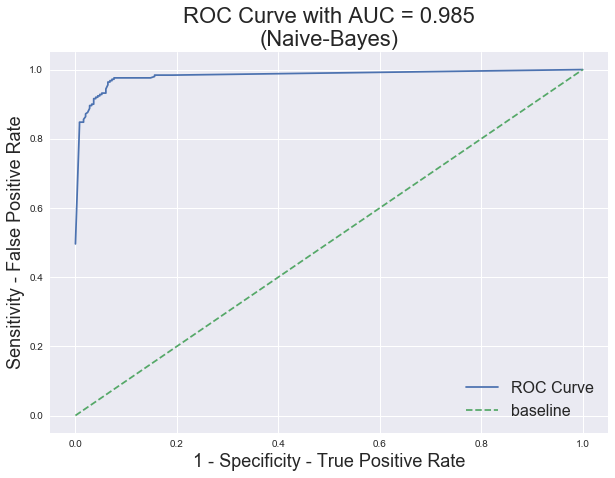

In [915]:
draw_roc(pred_df, "actual", "pred", "Naive-Bayes")

The ROC Curve shown above shows that the two classes are quite distinct with the area under the curve as quite large and does not lie on the baseline. This means that the classification is very distinct between the two classes. 

However, the Naive-Bayes model does slightly better with AUC = 0.985 as compared to the Logistic Regression model. 

# Random Forest Model

## Using GridSearch to tune hyperparameters

In [916]:
rf = RandomForestClassifier()

In [917]:
rf_params = {'n_estimators': [25, 100, 200],
             'max_depth': [None, 1, 3, 5, 7, 9], 
             'max_features': [3, 5, 6]
    
}

In [918]:
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=1, n_jobs=-1)
gs_rf.fit(X_train_cvec, y_train)
print('Best score:', gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/clementow/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  6.7min finished


Best score: 0.9325767690253671


{'max_depth': None, 'max_features': 5, 'n_estimators': 200}

## Re-initialising Random Forest Model with best parameters

In [928]:
rf_best = RandomForestClassifier(max_depth=None, max_features=5, n_estimators=200)

In [929]:
rf_best.fit(X_train_cvec, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [930]:
print("Random Forest Model training score: ", rf_best.score(X_train_cvec, y_train))
print("Random Forest Model test score:", rf_best.score(X_test_cvec, y_test))

Random Forest Model training score:  1.0
Random Forest Model test score: 0.944


Using the random forest model seems to introduce overfitting to the training data. This probably due to the large depth of the tree and lowering it might help in it. 

In [931]:
max_depth = list()
for tree in rf_best.estimators_:
    max_depth.append(tree.tree_.max_depth)

In [932]:
print(max_depth[np.argmin(max_depth)])
print(max_depth[np.argmax(max_depth)])
np.mean(max_depth)

197
314


257.095

Getting the min, max and mean max depth of the trees for the random forest model that had `max_depth=None`. And we will use the lower range depth to see if it will reduce overfitting. 

In [939]:
rf_best = RandomForestClassifier(max_depth=197, max_features=5, n_estimators=200)

In [940]:
rf_best.fit(X_train_cvec, y_train)
print("Random Forest Model training score: ", rf_best.score(X_train_cvec, y_train))
print("Random Forest Model test score:", rf_best.score(X_test_cvec, y_test))

Random Forest Model training score:  1.0
Random Forest Model test score: 0.95


Unfortunately, by reducing the depth did not reduce overfitting but surprisingly increased the test score at 0.95.  

## Random Forest most important features 

In [935]:
word_imp_ = pd.DataFrame({'word': cvec.get_feature_names() , 'feature_importance': rf_best.feature_importances_})

In [936]:
word_imp_.sort_values(by='feature_importance', ascending=False).head(20)

,word,feature_importance
2738,studi,0.016181
2896,thi,0.011337
1939,new,0.009740
1213,go,0.008808
1175,get,0.008205
1028,feel,0.007075
3238,wa,0.006935
2376,research,0.006780
677,day,0.006267
1544,know,0.005820


For random forest model, it is not possble to see which distinct words are belonging to a particular class. All we can interpret here is that the above are the most important features that were used to split the trees in the random forest. 

## ROC Curve

In [957]:
pred_proba_rf = rf_best.predict_proba(X_test_cvec)

#extracting out the n_class probabilities for calc ROC AUC Score
rf_pred_sample_proba = []
for i in pred_proba_rf:
    rf_pred_sample_proba.append(i[1])

The above is to get the probabilistic classification: a majority vote among estimators gives an estimate of the probability. This will be used to calculate the ROC AUC score. 

In [958]:
print("ROC AUC Score: ", roc_auc_score(y_test, rf_pred_sample_proba))

ROC AUC Score:  0.989816


In [959]:
#Put the actual values and predicted probabilities in a dataframe
pred_df = pd.DataFrame({'actual': y_test, 'pred': rf_pred_sample_proba})

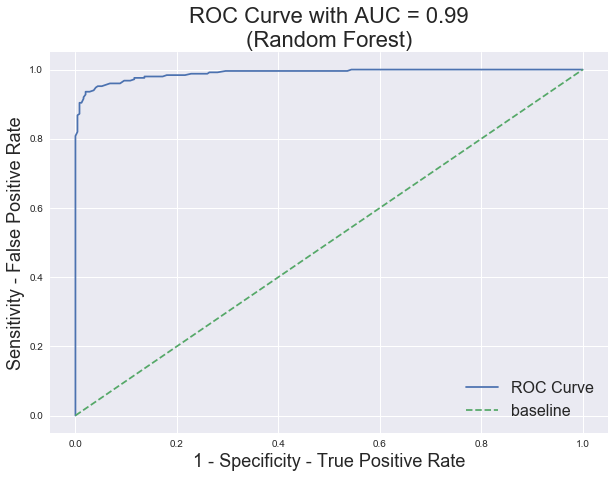

In [960]:
draw_roc(pred_df, "actual", "pred", "Random Forest")

The ROC AUC score is by far the best so far with a near perfect score of 0.99 among all the models that is tested. 

# Summary

## Best model


| Model               | Training Score | Test Score | ROC AUC Score |
|---------------------|----------------|------------|---------------|
| Logistic Regression | 0.999          | 0.948      | 0.98          |
| Naive-Bayes         | 0.962          | 0.946      | 0.985         |
| Random Forest       | 1.0            | 0.944      | 0.99          |

The best model in terms of test score will be the Logistic Regression model with a relatively goof ROC AUC score of 0.98 which is pretty close to the other models. 

However, the ultimate winner would be the __Naive-Bayes model__. Its test score is just shy of 0.02 at 0.946 which is pretty decent and this model generalises well and do not overfit the training data as compared to the others. One important point is that it greatly increases model result interpretability by clearly specifying the top features by subreddit. It also included words that are before or after which is a further plus point. Furthermore, its ROC AUC score is slightly higher than that of Logistic Regression indicating that the two classes are quite well split.

## Misclassificatons

The misclassification rate is relatively low at 26-27 out of close to 2000 posts depending on the model used. 

Looking into some of them, they were misclassified due to the fact that the post was quite similar to redditors who post on the other subreddit. For example, in a False Negative case (when prediction was _r/Psychology_) - "U.S. Suicide Rates Are the Highest They've Been Since World War II \[U.S. suicide rates\] are at their highest since World War II, according to federal data‚and the opioid crisis, widespread social media use and high rates of stress may be among the myriad contributing factors.". This kind of informative post usually appears on _r/Psychology_ and hence was misclassified as such. 

For the False Positive case (when the prediction was _r/MentalHealth_) - "In light of the very tragic Connecticut Elementary School shootings, everyone is now bringing up gun control again. What no one is talking about (and never seems to talk about) is helping to increase mental health healthcare in the country.  And it's pissing me off.". This post has alot of the author's feelings in it and thus makes the machine think that it is under _r/MentalHealth_ where redditors mostly pour our their feelings into their posts. 

There tends to be some anomalies as to the post structure and subjectivity that is posted to both subreddits. Since it is user driven community and as long as it does not flout any of the community guidelines the moderators will just let the post be. 

## Assumptions

- We are assuming that the models will treat each word as an independent variable.
- The bag of words approach is a good indicator for prediction.  
- We do not want to penalise document frequency as we are not doing Information Retrieval tasks.

# Recommendations

Looking at the context of words of how it is being used and linguistic features will be a better way of understanding text from a human. Of course, understanding sarcasm is one of the ongoing research which will help immensely in machine interpretability and higher accuracy rates. 

Sentiment analysis can be one interesting feature to input into the model to see if it will improve performance since these are subreddits that can potentially be very personal. 

Additionally, more features like length of posts can be identified and input into the model to see if it will increase accuracy scores. 